Updating data.............

YahooFinance("HD") has dubious total open-to-open returns for timestamps: DatetimeIndex(['1983-03-18 14:30:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)


.......

YahooFinance("MCD") has dubious total open-to-open returns for timestamps: DatetimeIndex(['1969-07-09 13:30:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)


......

YahooFinance("TRV") has dubious total open-to-open returns for timestamps: DatetimeIndex(['1986-06-12 13:30:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)


....


LARGEST SHARPE RATIO
gamma_trade and gamma_risk
(0.9, 5)
result

###########################################################
Universe size                                            31
Initial timestamp                       1963-02-01 14:30:00
Final timestamp                         2024-03-01 14:30:00
Number of periods                                       734
Initial value (USDOLLAR)                          1.000e+06
Final value (USDOLLAR)                            1.972e+09
Profit (USDOLLAR)                                 1.971e+09
                                                           
Avg. return (annualized)                              13.1%
Volatility (annualized)                               11.5%
Avg. excess return (annualized)                        8.4%
Avg. active return (annualized)                        8.4%
Excess volatility (annualized)                        11.5%
Active volatility (annualized)                        11.5%
                            

/Users/edkwang/.pyenv/versions/3.12.2/envs/rsch/lib/python3.12/site-packages/cvxportfolio/result.py:862: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover
/Users/edkwang/.pyenv/versions/3.12.2/envs/rsch/lib/python3.12/site-packages/cvxportfolio/result.py:862: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover



###########################################################
Universe size                                            31
Initial timestamp                       1963-02-01 14:30:00
Final timestamp                         2024-03-01 14:30:00
Number of periods                                       734
Initial value (USDOLLAR)                          1.000e+06
Final value (USDOLLAR)                            1.360e+11
Profit (USDOLLAR)                                 1.360e+11
                                                           
Avg. return (annualized)                              24.5%
Volatility (annualized)                               31.5%
Avg. excess return (annualized)                       19.7%
Avg. active return (annualized)                       19.7%
Excess volatility (annualized)                        31.6%
Active volatility (annualized)                        31.6%
                                                           
Avg. growth rate (annualized)          

/Users/edkwang/.pyenv/versions/3.12.2/envs/rsch/lib/python3.12/site-packages/cvxportfolio/result.py:862: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover


iteration 0
Current objective:
98290682486.0721
iteration 1
Current objective:
104498605908.20825
iteration 2
Current objective:
111143419991.31168
iteration 3
Current objective:
118265824361.65076
iteration 4
Current objective:
122624918712.27196
iteration 5
Current objective:
126843332920.00806
iteration 6
Current objective:
130775596314.60095
iteration 7
Current objective:
134763221841.03798
iteration 8
Current objective:
138648645226.4886
iteration 9
Current objective:
142616858938.14966
iteration 10
Current objective:
146451368155.85892
iteration 11
Current objective:
150426856539.62573
iteration 12
Current objective:
154489748314.7496
iteration 13
Current objective:
158227129399.41718
iteration 14
Current objective:
161400583069.30386
iteration 15
Current objective:
163922219449.15167
iteration 16
Current objective:
165526177300.5721
iteration 17
Current objective:
165577120084.05188
result_hyperparameter_optimized

###########################################################
Univ

/Users/edkwang/.pyenv/versions/3.12.2/envs/rsch/lib/python3.12/site-packages/cvxportfolio/result.py:862: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover


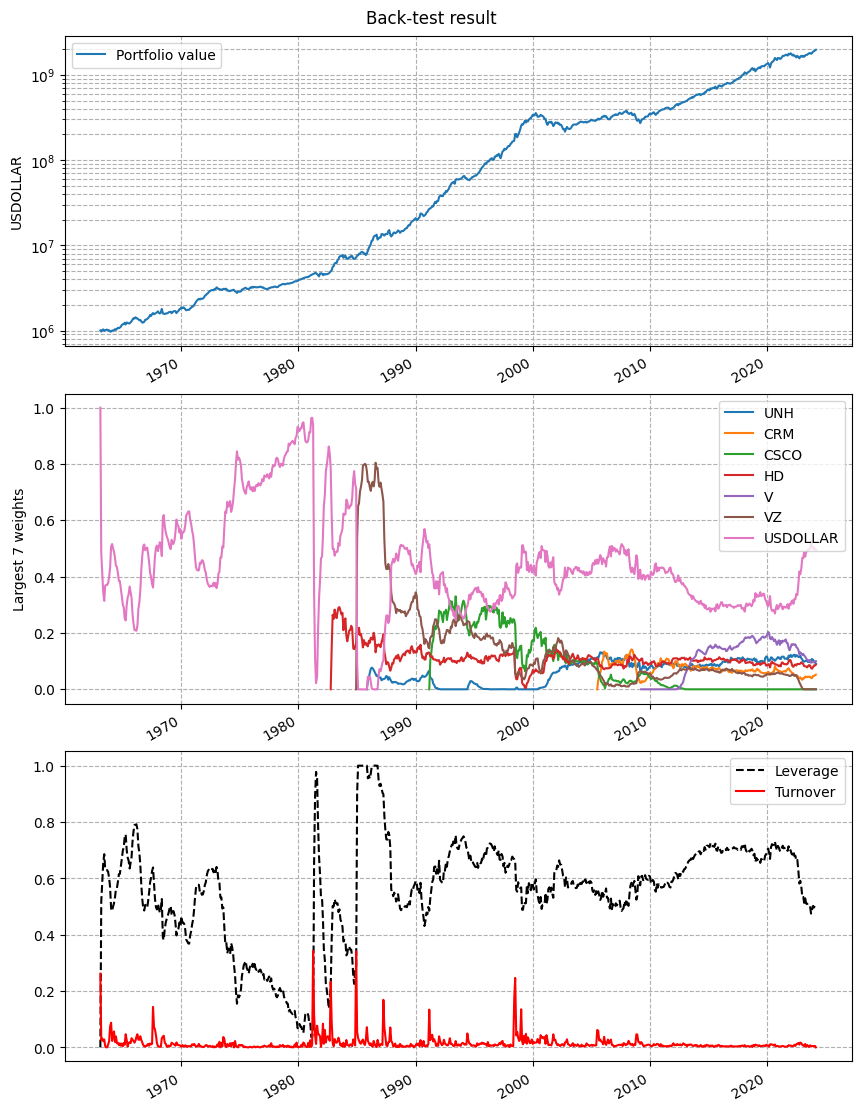

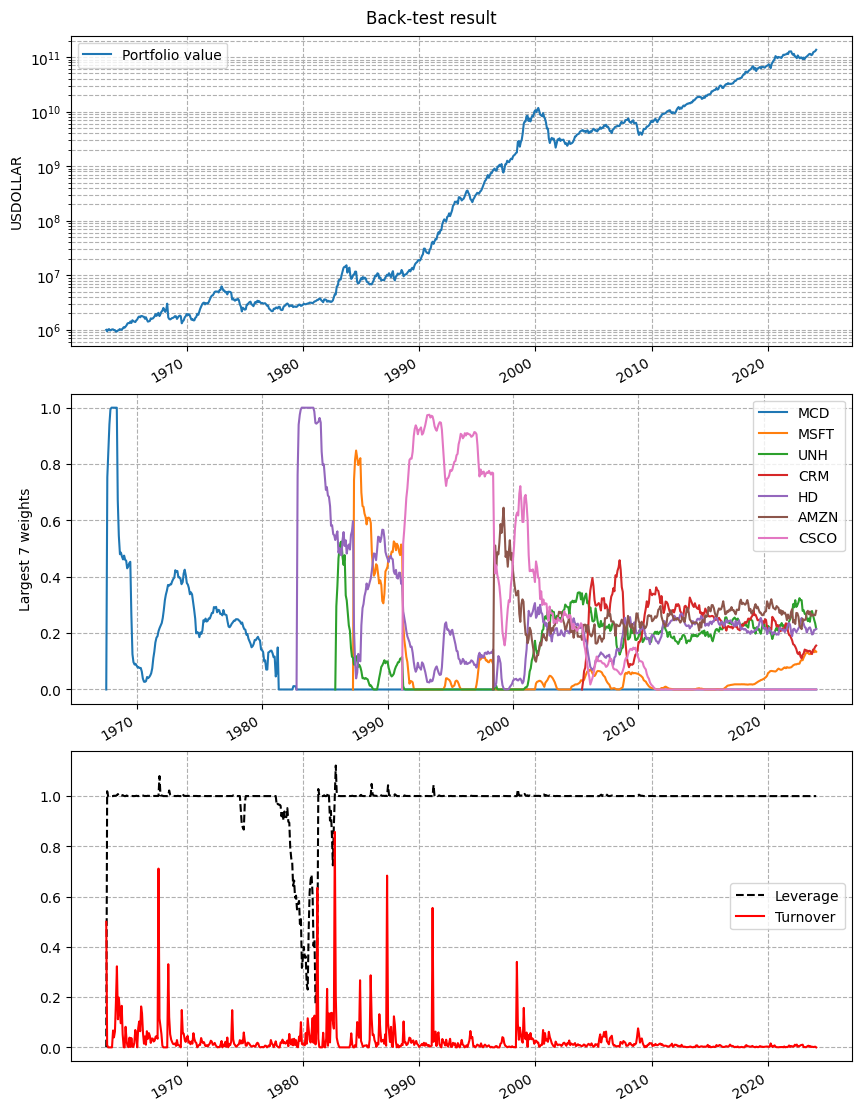

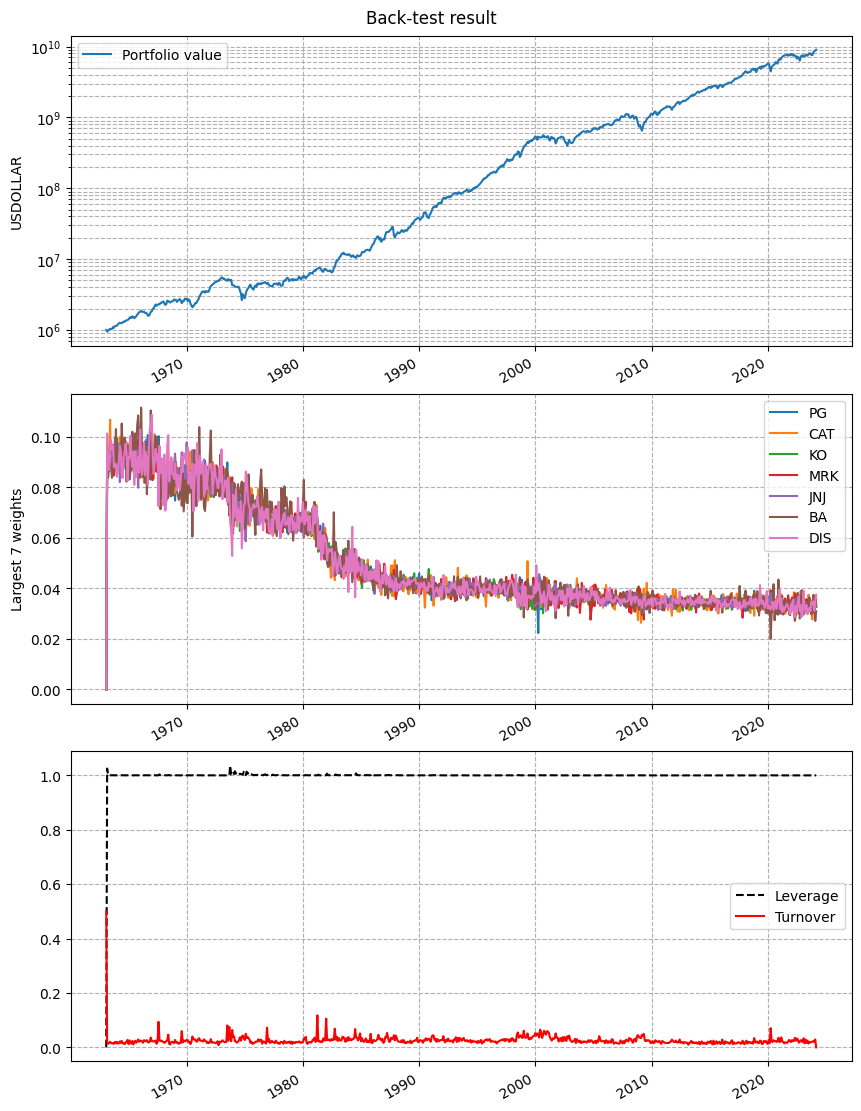

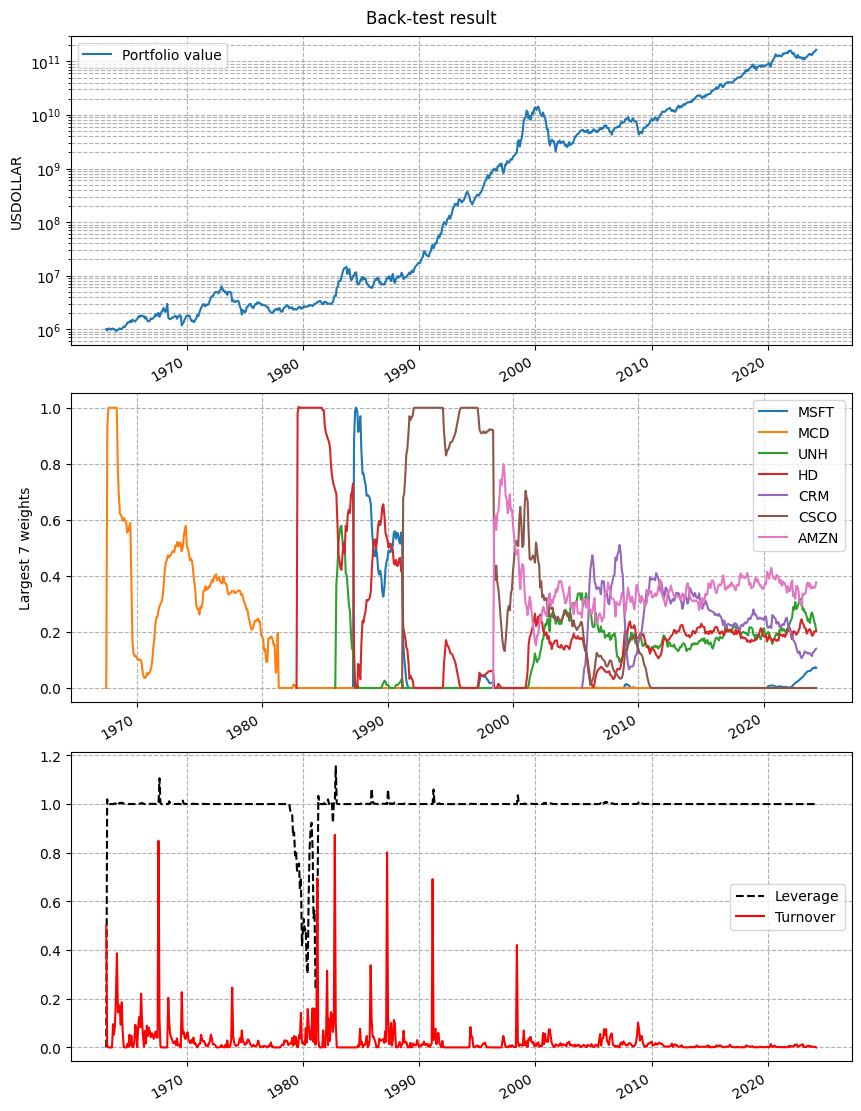

In [1]:
"""Example of long-only portfolio among DOW-30 components.

Monthly rebalance, backtest spans from the start of data of the
components of the current index (in the 60s), the other stocks
enter the backtest as times goes on. It ends today.

This uses an explicit loop to create Multi Period Optimization
policies with a grid of values for the risk term multiplier
and the transaction cost term multiplier. (We don't use the
holding cost term because the portfolio is long-only.)

All result objects are collected, and then the one with
largest Sharpe ratio, and the one with largest growth rate,
are shown.

Finally, we show the effect of using symbolic hyper-parameters,
:class:`cvxportfolio.Gamma`, as multipliers of the risk and transaction
cost terms. We can optimize on those explicitely, by finding the values
that maximize some back-test metric (in this case, profit).

You can run this with this command from the parent directory:

.. code-block:: bash

    python -m examples.dow30
"""

# Uncomment the logging lines to get online information
# from the parallel backtest routines

# import logging
# logging.basicConfig(level=logging.INFO)
# log=logging.getLogger('=>')

import os

import matplotlib.pyplot as plt
import numpy as np

import cvxportfolio as cvx

from universes import DOW30

sim = cvx.StockMarketSimulator(DOW30, trading_frequency='monthly')

def make_policy(gamma_trade, gamma_risk):
    """Build MPO policy given risk and trans. cost multipliers.

    :param gamma_trade: Transaction cost multiplier.
    :type gamma_trade: float or int
    :param gamma_risk: Risk model multiplier.
    :type gamma_risk: float or int
    :return: Multi-period optimization policy with given
        hyper-parameter values.
    :rtype: cvxportfolio.Policy
    """
    return cvx.MultiPeriodOptimization(cvx.ReturnsForecast()
        - gamma_risk * cvx.FactorModelCovariance(num_factors=10)
        - gamma_trade * cvx.StocksTransactionCost(),
        [cvx.LongOnly(), cvx.LeverageLimit(1)],
        planning_horizon=6, solver='ECOS')

keys = [(gamma_trade, gamma_risk) for
    gamma_trade in np.array(range(10))/10 for gamma_risk in [.5, 1, 2, 5, 10]]
ress = sim.backtest_many([make_policy(*key) for key in keys])


print('\n\nLARGEST SHARPE RATIO')
idx = np.argmax([el.sharpe_ratio for el in ress])

print('gamma_trade and gamma_risk')
print(keys[idx])

print('result')
print(ress[idx])

ress[idx].plot()
# we use this to save plots for the documentation
if 'CVXPORTFOLIO_SAVE_PLOTS' in os.environ:
    plt.savefig('dow30_largest_sharpe_ratio.png')

print('\n\nLARGEST GROWTH RATE')
idx = np.argmax([el.growth_rates.mean() for el in ress])

print('gamma_trade and gamma_risk')
print(keys[idx])

print('result')
print(ress[idx])

ress[idx].plot()
if 'CVXPORTFOLIO_SAVE_PLOTS' in os.environ:
    plt.savefig('dow30_largest_growth_rate.png')

print('\n\nUNIFORM (1/N) ALLOCATION FOR COMPARISON')
result_uniform = sim.backtest(cvx.Uniform())

print('result_uniform')
print(result_uniform)

result_uniform.plot()
if 'CVXPORTFOLIO_SAVE_PLOTS' in os.environ:
    plt.savefig('dow30_uniform.png')

print('\n\nHYPER-PARAMETER OPTIMIZATION')
policy = cvx.MultiPeriodOptimization(cvx.ReturnsForecast()
        - cvx.Gamma() * cvx.FactorModelCovariance(num_factors=10)
        - cvx.Gamma() * cvx.StocksTransactionCost(),
        [cvx.LongOnly(), cvx.LeverageLimit(1)],
        planning_horizon=6, solver='ECOS')
sim.optimize_hyperparameters(policy, objective='profit')
result_hyperparameter_optimized = sim.backtest(policy)

print('result_hyperparameter_optimized')
print(result_hyperparameter_optimized)

result_hyperparameter_optimized.plot()

if 'CVXPORTFOLIO_SAVE_PLOTS' in os.environ:
    plt.savefig('dow30_hyperparameter_optimized.png')
else:
    plt.show()